# Maria Chernyavskaya, Lab 7&8, Section AB, Memo-style

## Introduction

The following analysis aims to identify contaminants and remove them from the dataset, and to determine how much more sensitive the measurement is after the cuts, as compared to before. Since the dataset is rather large, I will analyze  a part of the file that corresponds to a random sample of 100 out of the original 630 cross-correlation baselines. For increased clarity, I will be executing the analysis on one randomly chosen baseline (#25), and then iterating across the entire random sample. The two collapsed cells below contain code that enables the entire analysis (package upload and data read-in).

In [1]:
# import pyuvdata everytime for JupyterHub
! conda install pyuvdata -y > /dev/null

%matplotlib inline
from pyuvdata import UVData
import numpy as np
from matplotlib import pyplot as plt
import scipy
from scipy import stats
import matplotlib.colors as colors
plt.rcParams["figure.figsize"] = (10,6)



==> WARNING: A newer version of conda exists. <==
  current version: 4.7.12
  latest version: 4.9.2

Please update conda by running

    $ conda update -n base conda




In [2]:
uv = UVData()
uv.read('/home/jovyan/Phys434_BigData/zen.2459122.62018.mini.sum.uvh5')
pairs = uv.get_antpairs()
freqs = uv.freq_array[0]*1e-6 # gets frequencies associated with each channel, in MHz
base = pairs[25]
data_base = uv.get_data(base)
data_base.shape

(20, 1536)

## Initial data axes
The initial dataset has the following axes:

𝑣𝑎𝑏  (each cross-power measurement between antennas  𝑎  and  𝑏 . This labelled  𝑣𝑎𝑏  because the measurements are called 'visibilities'. A complex quantity in Jansky units.)

𝑡𝑛  (each time step, seconds units.)

𝑓  (each frequency, in MHz)

## Single antenna pair analysis

### Signal removal
The data contains both sky signal (good) and contamination (bad). To make a background distribution, sky signal must be removed. The sky signal in this data is very steady in time in comparison to the measurements, as most of the sources are distant radio galaxies whose intensity is steady over millions of years, and they move slowly across the sky. The measurements are taken approximately every 10 seconds, so by subtracting neighboring time samples, the astrophysical signals can be removed. Many of the contaminants have a lot of variability, either because the brightness is quickly fluctuating or they are rapidly moving on the sky, thus this procedure will remove most of the sky signal, but much of the contamination will remain. Here is the code for this procedure, demonstrated on baseline 25:

In [3]:
# shape is 20: ammount of times. Subtraction is of times (n+1) - (n), and there are 19 subtractions
def back_gone(line):
    clean1 = []
    for i in range(19):
        clean1.append(line[i+1]-line[i])
    clean1=np.array(clean1)
    return clean1

clean1 = back_gone(data_base)

Since I am using only one baseline, I do not have to worry about throwing out 𝑎=𝑏  measurements (e.g.  𝑣𝑎𝑎). I will mention this again when the entire sub-dataset is analyzed.

### Visualization of Data: Signal removal
In order to show the signal removal better, I am plotting the subtraction between time 11 and 10 below, and logging the data to see it better.

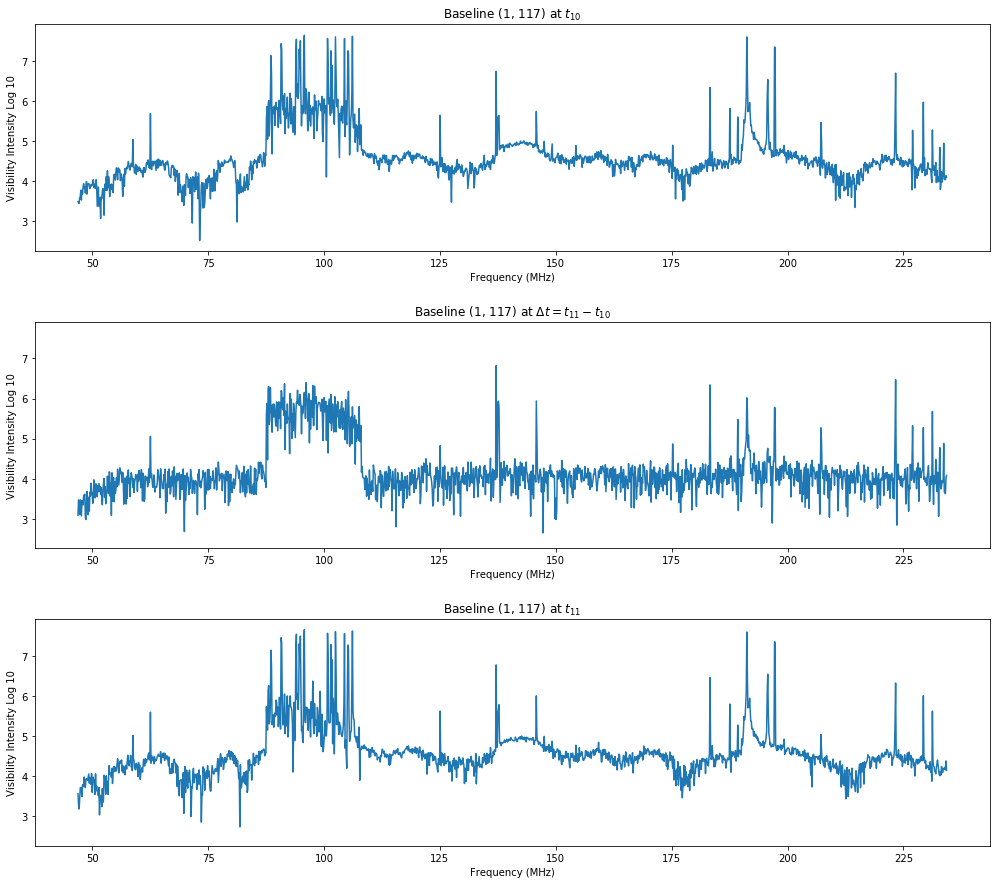

In [4]:
n=10
fig,ax=plt.subplots(3,1,figsize=(14,12),sharey=True)
fig.tight_layout(h_pad=5)
ax[0].plot(freqs,np.log10(np.abs(data_base[n])))
ax[0].set_xlabel('Frequency (MHz)')
ax[0].set_ylabel('Visibility Intensity Log 10')
ax[0].set_title(fr"Baseline {base} at $t_{ {n} } $",fontsize=12);
ax[1].plot(freqs,np.log10(np.abs(clean1[n])))
ax[1].set_xlabel('Frequency (MHz)')
ax[1].set_ylabel('Visibility Intensity Log 10')
ax[1].set_title(fr"Baseline {base} at $\Delta t = t_{ {n+1} } - t_{ {n} }$",fontsize=12);
ax[2].plot(freqs,np.log10(np.abs(data_base[n+1])))
ax[2].set_xlabel('Frequency (MHz)')
ax[2].set_ylabel('Visibility Intensity Log 10')
ax[2].set_title(fr"Baseline {base} at $t_{ {n+1} }$",fontsize=12);

In the above plots, we can see that the overall trends of the background is a line fluctuating between 4 and 5 visibilities, with a sudden jump from 85 to 115 MHz. These graphs are overplotted below for a comparitive representation of the effect that this subtraction has: 

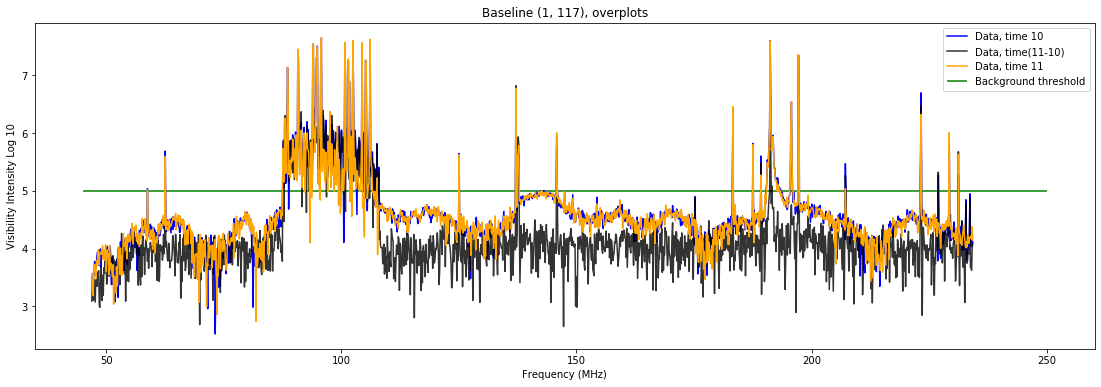

In [5]:
n=10
fig,ax=plt.subplots(1,1,figsize=(19,6))
ax.plot(freqs,np.log10(np.abs(data_base[n])), label = "Data, time 10", color = "blue")
ax.plot(freqs,np.log10(np.abs(clean1[n])), label = "Data, time(11-10)", color = "black", alpha = 0.8)
ax.plot(freqs,np.log10(np.abs(data_base[n+1])), label = "Data, time 11", color = "orange")
ax.hlines(5, 45, 250, label = "Background threshold", color = "green") 
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('Visibility Intensity Log 10')
ax.set_title(fr"Baseline {base}, overplots",fontsize=12)
ax.legend(loc=0);

### Visualization: Histograms
To properly analyze this data for the presence of a true signal, multiple visualizations are necessary. Below are histograms of the visibility magnitude. Histogramming magnitude allows us to see the background relative to frequency, and to identify the shape.

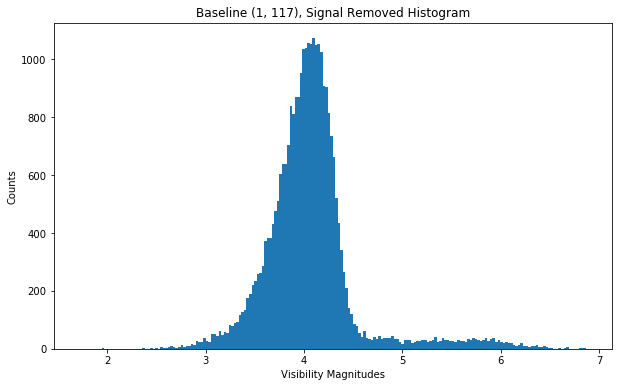

In [6]:
plt.subplots()
cleanf = np.abs(clean1).flatten()
plt.hist(np.log10(cleanf),bins=200);
plt.title(f'Baseline {base}, Signal Removed Histogram')
plt.xlabel('Visibility Magnitudes')
plt.ylabel('Counts');

The horizontal line at "5" magnitudes in the overplotted graph shows another cut-off for the background. I have used it to clean up the background distribution even more:

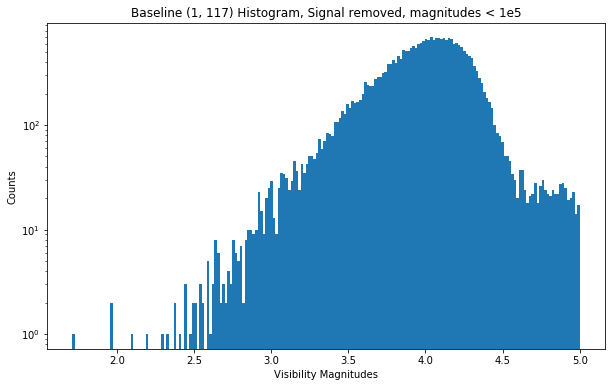

In [7]:
plt.subplots()
cleanf = np.abs(clean1).flatten()
vro1 = cleanf[cleanf < 1e5]
plt.yscale('log')
plt.hist(np.log10(vro1),bins=200);
plt.title(f'Baseline {base} Histogram, Signal removed, magnitudes < 1e5')
plt.xlabel('Visibility Magnitudes')
plt.ylabel('Counts');

This histogram looks almost Gaussian before the removal of points over 10^5. After this, the shape is no longer symmetrical: it is skewed to the right. This shape is remniscent of a left-skew Rayleigh. To identify the exact type of distribution would require further analysis, which I will return to once I look at more than one baseline.

### Visualization of Data: Waterfall plots
Since the data given contains visibility, time and frequency, it is useful to visualize it in a 2-dimensional way. Of particular interest is a waterfall plot with power 𝑣 vs. time and frequency. Since visibility is a complex number, the visualizations below only include the real values. The imaginary part of visibility is the phase differences. First, I will provide waterfall plots of the raw data, followed by the signal-removed data, labeled accordingly:

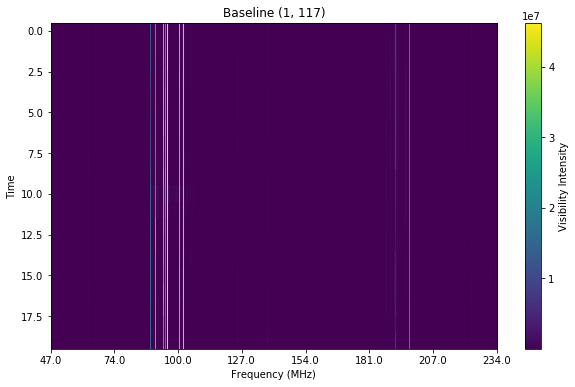

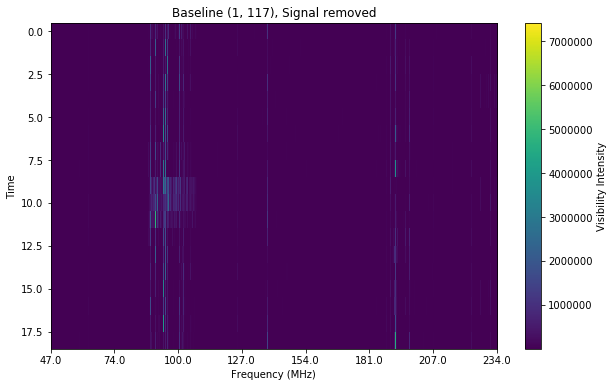

In [8]:
fig, axs = plt.subplots(1,1)
im = plt.imshow(np.abs(data_base),aspect='auto',interpolation='nearest')
cbar = fig.colorbar(im,label='Visibility Intensity')
axs.set_ylabel('Time')
axs.set_xlabel('Frequency (MHz)')
xticks = [int(i) for i in np.linspace(0,len(freqs)-1,8)]
_ = axs.set_xticks(xticks)
xticklabels = np.around(freqs[xticks],0)
_ = axs.set_xticklabels(xticklabels)
plt.title(f'Baseline {base}')
plt.show()

fig, axs = plt.subplots(1,1)
im = plt.imshow(np.abs(clean1),aspect='auto',interpolation='nearest')
cbar = fig.colorbar(im,label='Visibility Intensity')
axs.set_ylabel('Time')
axs.set_xlabel('Frequency (MHz)')
xticks = [int(i) for i in np.linspace(0,len(freqs)-1,8)]
_ = axs.set_xticks(xticks)
xticklabels = np.around(freqs[xticks],0)
_ = axs.set_xticklabels(xticklabels)
plt.title(f'Baseline {base}, Signal removed')
plt.show()

As can be seen from the plots above, the signals from the original are mostly cleaned out, and the second waterfall plot is very low in intensity across the board. To mitigate this, the visibility has been logged and plotted below:

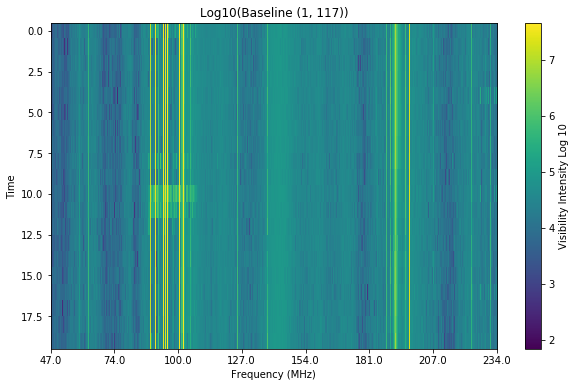

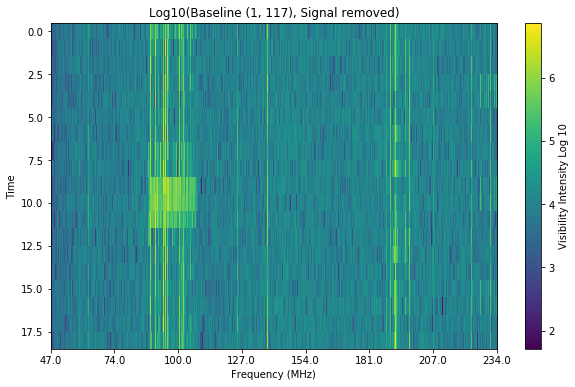

In [9]:
fig, axs = plt.subplots(1,1)
im = plt.imshow(np.log10(np.abs(data_base)),aspect='auto',interpolation='nearest')
cbar = fig.colorbar(im,label='Visibility Intensity Log 10')
axs.set_ylabel('Time')
axs.set_xlabel('Frequency (MHz)')
xticks = [int(i) for i in np.linspace(0,len(freqs)-1,8)]
_ = axs.set_xticks(xticks)
xticklabels = np.around(freqs[xticks],0)
_ = axs.set_xticklabels(xticklabels)
plt.title(f'Log10(Baseline {base})')
plt.show()

fig, axs = plt.subplots(1,1)
im = plt.imshow(np.log10(np.abs(clean1)),aspect='auto',interpolation='nearest')
cbar = fig.colorbar(im,label='Visibility Intensity Log 10')
axs.set_ylabel('Time')
axs.set_xlabel('Frequency (MHz)')
xticks = [int(i) for i in np.linspace(0,len(freqs)-1,8)]
_ = axs.set_xticks(xticks)
xticklabels = np.around(freqs[xticks],0)
_ = axs.set_xticklabels(xticklabels)
plt.title(f'Log10(Baseline {base}, Signal removed)')
plt.show()

In semi-log space, the difference is less stark, but this is due to the properties of the space itself. The stretch of yellow colour around time 10 is more obvious in the logged, signal-free data than in the logarithm. The bright yellow line between 181 and 207 MHz is still present, and should perhaps be analyzed via a jackknife or data cut.

## Average visibility plots and general feature exploration 
If a signal comes from far away, it is expected to be visible in all antenna pairs. To increase sensitivity, an average of all baseline pairs, with 𝑣𝑎𝑎  values removed is created. Since the visibilities are complex, considerations should be made to procur the average of the magnitudes <|𝑣|>𝑎𝑏 , where 𝑎 and 𝑏 cover all values 𝑎≠𝑏 . For this evaluation, 100 baselines have been randomly-selected:

In [10]:
np.random.seed(3)
bline = []
for i in range(len(pairs)):
    if pairs[i][0]!= pairs[i][1]:
        bline.append(pairs[i])
blines = np.random.choice(np.arange(len(bline),dtype=int),size=100,replace=False)
bs = np.array(bline)
lines = bs[blines]

In [11]:
#Average non-signal removed
avg1 = []
for i in range(20):
    ma= []
    for j in range(len(lines)):
        sha = abs(uv.get_data(lines[j]))
        ma.append(sha[i])
    ma = np.array(ma)
    mc = ma.mean(axis=0)
    avg1.append(mc)
avg1 = np.array(avg1)
avg1.shape

(20, 1536)

Using the same procedures as with the single-baseline, the signals are removed from the data.

In [12]:
#Average signal removed
clean2 =[ ]
for i in range(19):
    bt = []
    for j in range(len(lines)):
        d = abs(back_gone(uv.get_data(lines[j])))
        bt.append(d[i])
    bt = np.array(bt)
    mc = bt.mean(axis=0)
    clean2.append(mc)
clean2 = np.array(clean2)
clean2.shape

(19, 1536)

Overall, the background lies below a threshold of about 1.5e4 Magnitudes, as shown below:

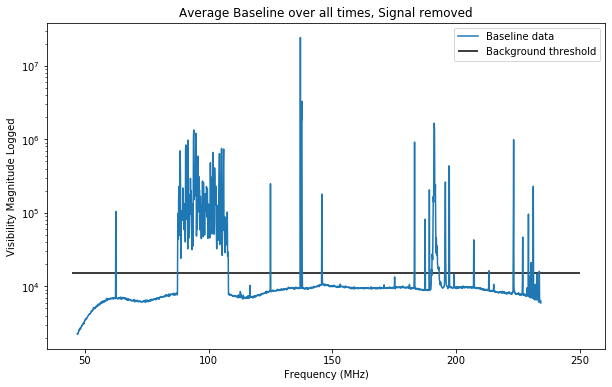

In [13]:
plt.subplots()
plt.yscale('log')
plt.plot(freqs,np.abs(np.mean(clean2,axis=0)), label = "Baseline data")
plt.hlines(1.5e4, 45, 250, label = "Background threshold")
plt.title('Average Baseline over all times, Signal removed')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Visibility Magnitude Logged')
plt.legend(loc=0);

This can be used to further clean up the background distribution, like with the singular baseline. Both graphs are in semi-log space:

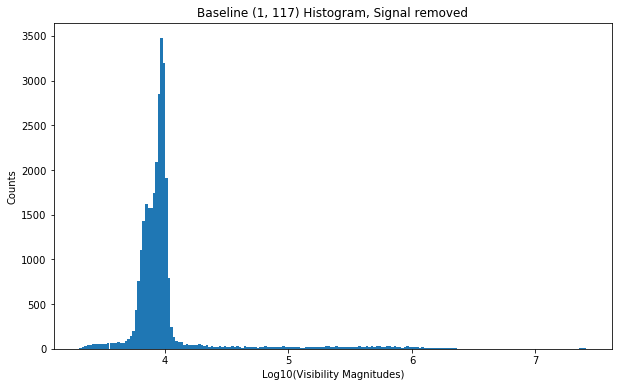

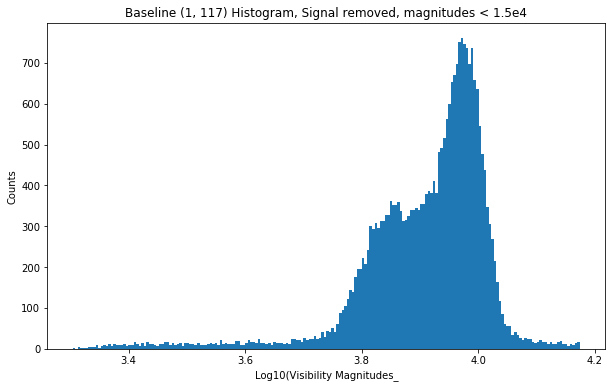

In [14]:
plt.subplots()
clean2f = np.abs(clean2).flatten()
plt.hist(np.log10(clean2f),bins=200);
plt.title(f'Baseline {base} Histogram, Signal removed')
plt.xlabel('Log10(Visibility Magnitudes)')
plt.ylabel('Counts');

plt.subplots()
clean2f = np.abs(clean2).flatten()
vro2 = clean2f[clean2f < 1.5e4]
plt.hist(np.log10(vro2),bins=200);
plt.title(f'Baseline {base} Histogram, Signal removed, magnitudes < 1.5e4')
plt.xlabel('Log10(Visibility Magnitudes_')
plt.ylabel('Counts');

This distribution now looks almost bimodal, and even wider, perhaps a left-skewed Rayleigh. I have once again visualized this in waterfall plots:

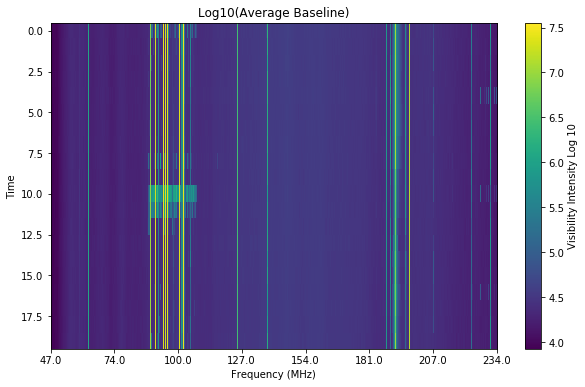

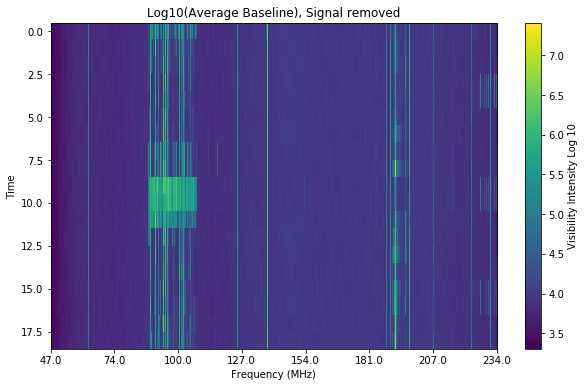

In [15]:
fig, axs = plt.subplots(1,1)
im = plt.imshow(np.log10(np.abs(avg1)),aspect='auto',interpolation='nearest')
cbar = fig.colorbar(im,label='Visibility Intensity Log 10')
axs.set_ylabel('Time')
axs.set_xlabel('Frequency (MHz)')
xticks = [int(i) for i in np.linspace(0,len(freqs)-1,8)]
_ = axs.set_xticks(xticks)
xticklabels = np.around(freqs[xticks],0)
_ = axs.set_xticklabels(xticklabels)
plt.title(f'Log10(Average Baseline)')
plt.show()

fig, axs = plt.subplots(1,1)
im = plt.imshow(np.log10(np.abs(clean2)),aspect='auto',interpolation='nearest')
cbar = fig.colorbar(im,label='Visibility Intensity Log 10')
axs.set_ylabel('Time')
axs.set_xlabel('Frequency (MHz)')
xticks = [int(i) for i in np.linspace(0,len(freqs)-1,8)]
_ = axs.set_xticks(xticks)
xticklabels = np.around(freqs[xticks],0)
_ = axs.set_xticklabels(xticklabels)
plt.title(f'Log10(Average Baseline), Signal removed')
plt.show()

Using the Radio Frequency Spectrum Allocation Chart for South Africa, found [here](https://www.ee.co.za/wp-content/uploads/2015/03/csir-035-02-2015_.jpg),
![Image](https://www.ee.co.za/wp-content/uploads/2015/03/csir-035-02-2015_.jpg)

It becomes obvious that some of the bright signals between 87.5 MHz and 108.0 MHz are most likely due to broadcasting.

## Jackknife tests
The natural progression in cleaning up this data is introducing a jackknife test. I will follow the steps to a jackknife test:

a) Come up with a concern.

One concern is that the background varies with frequency, considering there is broadcasting interfering with the data collection. Stated more concisely: Does the shape of the background distribution change depending on which frequency is observe?"

b) Identify a data cut such that if the concern is true the contamination should appear in one data set but not the other.

I will pick a frequency range of 65-80 MHz, and 155-170 MHz, since there are no obvious peaks in the data in those regions.

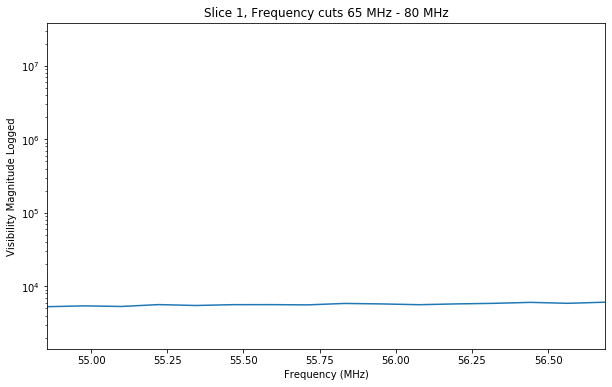

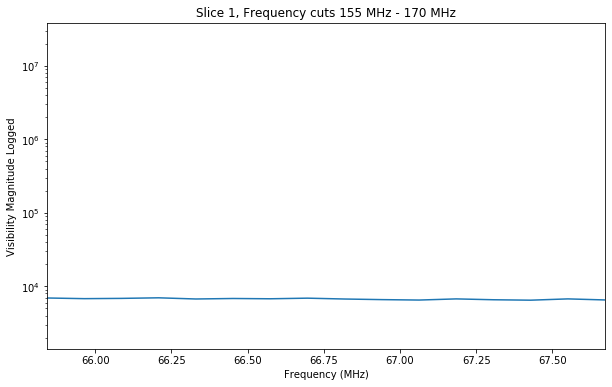

In [16]:
plt.subplots()
plt.yscale('log')
plt.plot(freqs,np.abs(np.mean(clean2,axis=0)));
plt.xlim(freqs[65],freqs[80])
plt.xlabel('Frequency (MHz)')
plt.ylabel('Visibility Magnitude Logged');
plt.title(f'Slice 1, Frequency cuts 65 MHz - 80 MHz');

plt.subplots()
plt.yscale('log')
plt.plot(freqs,np.abs(np.mean(clean2,axis=0)));
plt.xlim(freqs[155],freqs[170])
plt.xlabel('Frequency (MHz)')
plt.ylabel('Visibility Magnitude Logged');
plt.title(f'Slice 1, Frequency cuts 155 MHz - 170 MHz');

c) Calculate the histograms for each dataset, including the error bars on the histogram. Plot the histograms.

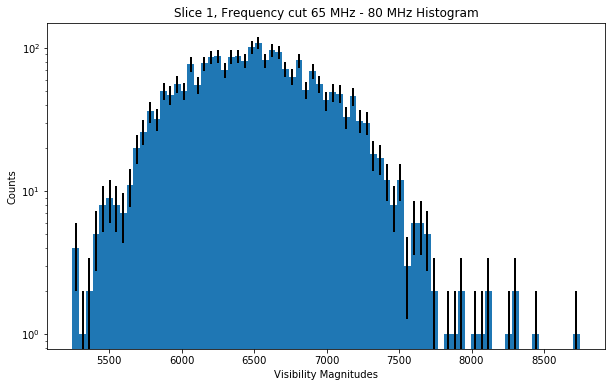

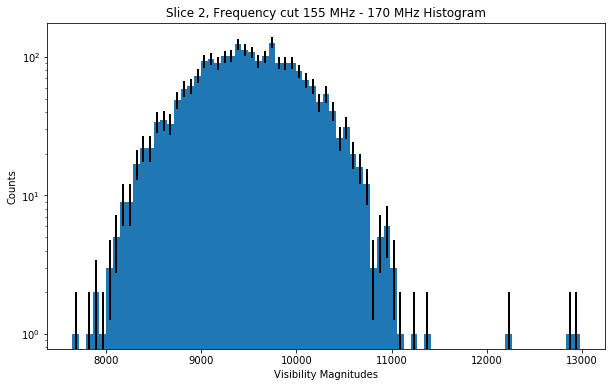

In [17]:
fig,ax=plt.subplots()
low = abs(freqs-65).argmin()
high = abs(freqs-80).argmin()
cut = np.abs((clean2[:,low:high].flatten()))
vro3 = cut
plt.yscale('log')
n1,bins,p=plt.hist(vro3,bins=75);
b=bins[:-1]+(bins[1+20]-bins[0+20])/2
plt.errorbar(b,n1,yerr=np.sqrt(n1),elinewidth=2,linewidth=0,color='k');
plt.xlabel('Visibility Magnitudes')
plt.ylabel('Counts');
plt.title('Slice 1, Frequency cut 65 MHz - 80 MHz Histogram');

fig,ax=plt.subplots()
low = abs(freqs-155).argmin()
high = abs(freqs-170).argmin()
cut = np.abs((clean2[:,low:high].flatten()))
vro4 = cut
plt.yscale('log')
n2,bins,p=plt.hist(vro4,bins=75);
b=bins[:-1]+(bins[1+20]-bins[0+20])/2
plt.errorbar(b,n2,yerr=np.sqrt(n2),elinewidth=2,linewidth=0,color='k');
plt.xlabel('Visibility Magnitudes')
plt.ylabel('Counts');
plt.title('Slice 2, Frequency cut 155 MHz - 170 MHz Histogram');

So far, both the backgrounds in each time cut appear Gaussian in shape (parabolic in semi-log space). The last step is to perform the actual jackknife by subtracting the slices.

d) Subtract the histograms and check for consistency to within the expected error. Nota bene: the errors on the difference are not identical to the errors on each histogram individually.

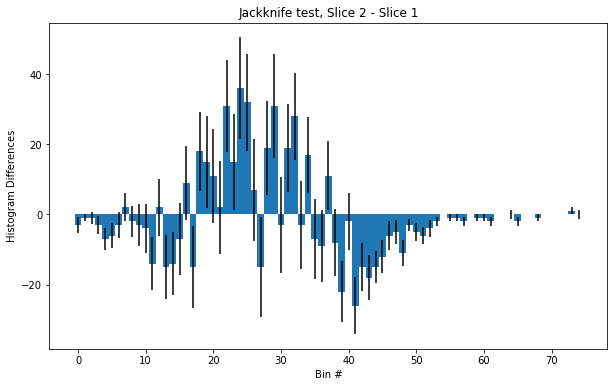

In [18]:
plt.subplots()
diff=n2-n1
plt.bar(np.arange(len(diff)),diff,width=1,yerr=np.sqrt(n1+n2))
plt.xlabel('Bin #')
plt.title('Jackknife test, Slice 2 - Slice 1')
plt.ylabel('Histogram Differences');

As can be seen from the above jackknife plot, the errors are centered around zero, which is good. However, the error bars do not all overlap the zero, meaning there is too much variance for the jackknife to pass. Of particular note is the positive difference in the middle, which means that histogram two is much taller than one, and the opposite is true for the edge bins.

## Data cuts
Based on the identified features and jackknife tests, a set of cuts will be used to remove contaminated data. This cut should include the removal of features such as the broadcasting frequencies, the aeronautical communications, and the satellites. In addition, the bins that have error bars furthest away from zero should be removed. If there were to be a candidate signal in this space, it would have a higher significance than in the general data set, per the "look elsewhere" phenomenon. While increased sensitivity is achieved by using a larger dataset, removing data actually betters analysis because more data causes a broader distribution. The background being variable over frequency means that using smaller ranges and data is better for the science which is being attempted.

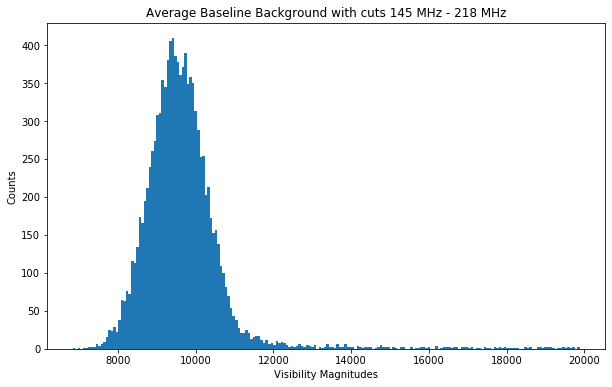

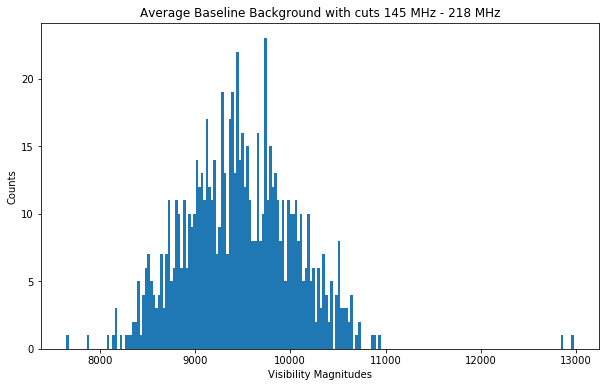

In [19]:
fig,ax=plt.subplots()
fl = np.abs((clean2[:,800:1400].flatten()))
vro3 = fl[fl < 2e4]
#plt.yscale('log')
#plt.hist(bt1f,bins=200);
n1,bins,p=plt.hist(vro3,bins=200);
plt.title(f'Average Baseline Background with cuts {freqs[800]:0.0f} MHz - {freqs[1400]:0.0f} MHz')
plt.xlabel('Visibility Magnitudes')
plt.ylabel('Counts');



fig,ax=plt.subplots()
low = abs(freqs-165).argmin()
high = abs(freqs-170).argmin()
avgg = np.abs(clean2[:,low:high]).flatten()
#total_avg = avgg[:,low:high]
#fl = np.abs((avg1sr[:,800:1400].flatten()))
#vro3 = total_avg[total_avg < 1.5e4]
#plt.yscale('log')
#plt.hist(bt1f,bins=200);
n1,bins,p=plt.hist(avgg,bins=200);
plt.title(f'Average Baseline Background with cuts {freqs[800]:0.0f} MHz - {freqs[1400]:0.0f} MHz')
plt.xlabel('Visibility Magnitudes')
plt.ylabel('Counts');

Note for Dr. Morales: I was somewhat confused on the execution of the data cuts-- in theory I understand the idea, but when I implemented, it looked very strange. I hope my theoretical discussion makes up for this strange practical result. I think I could possibly do more, but I have multiple essays and exams going on and I decided to stop here for the sake of my sanity. By Wednesday, I will probably have poked around some more, but since I'm getting feedback then anyways... I will fix any weirdness and incorporate all feedback before next weekend, as discussed previously. Thanks for an awesome quarter and course!